In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/lambda_max_v_bond_len_H_only.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")
merged_df.head()
# Effectively, I think of this as a left joining kraken_df on dft_df

,molecule_id,lambda_max,shift,Pd-H_length,smiles,dipolemoment_max,pyr_P_max,pyr_alpha_max,qpole_amp_max,qpoletens_xx_max,...,vbur_qvbur_max_boltzmann_average,vbur_qvbur_min_boltzmann_average,vbur_qvtot_max_boltzmann_average,vbur_qvtot_min_boltzmann_average,vbur_ratio_vbur_vtot_boltzmann_average,vbur_vbur_boltzmann_average,vbur_vtot_boltzmann_average,vmin_r_boltzmann_average,vmin_vmin_boltzmann_average,volume_boltzmann_average
0,8,395.4,0.0,2.30055,CC(C)(C)P(C(C)(C)C)C(C)(C)C,0.785410,0.814829,32.633045,2.286466,1.155208,...,20.849024,14.705131,92.370575,50.689070,0.277816,72.062120,253.71219,1.756687,-0.069888,320.95413
1,12,421.5,26.1,2.59931,CC(C)(C)CP(C(C)(C)C)C(C)(C)C,0.819760,0.883014,28.707630,1.997507,0.856250,...,21.402498,14.062596,89.652150,54.039700,0.271465,74.782196,271.61676,1.767097,-0.064135,345.01490
2,1648,378.0,-17.4,1.94427,CC(C)(C)P(c1cccc2ccccc12)C(C)(C)C,0.943379,0.852600,30.313591,5.221972,3.356086,...,27.215685,14.099444,146.207050,46.511883,0.235295,75.336480,322.30103,1.779128,-0.060278,385.63310
3,1656,414.7,19.3,2.29422,Cc1cc(C)c(P(C(C)(C)C)C(C)(C)C)c(C)c1,1.063524,0.785253,33.952614,4.349228,2.703184,...,27.946302,15.067517,128.196730,51.288940,0.252914,80.446860,320.88870,1.754941,-0.062705,392.55540
4,16511,369.7,-25.7,2.05612,CCC#CC(C)(C)P(CC(C)(C)C)CC(C)(C)C,0.828542,0.937721,21.047157,4.292618,3.905047,...,19.559307,15.134177,95.923110,64.802795,0.236930,76.982850,338.08795,1.775052,-0.056829,424.17822


In [3]:
# Let's start with the top 20 features in the first principal component from our PCA (see ligand_pca.ipynb)
# Then let's examine their multicollinearity and remove features until we have significantly reduced that.
# We can also use various algorithms to do feature selection for us at this point.

# Since these data are all related to complexes with some agostic interaction, I have decided to include the distance between
# Pd and H (Pd-H_length) to see if the model hones in on this feature and whether that is generally helpful to us.

first_pca_20_and_Pd_H_length = [
    "Pd-H_length",
    # "nbo_lp_P_percent_s_boltzmann_average",
    # "nbo_lp_P_occ_boltzmann_average",
    # "nmrtens_sxx_P_boltzmann_average",
    # "vmin_r_boltzmann_average",
    # "nmr_P_boltzmann_average",
    # "vbur_max_delta_qvtot_max",
    # "vbur_max_delta_qvtot_vburminconf",
    # "vbur_ratio_vbur_vtot_boltzmann_average",
    # "vbur_max_delta_qvtot_boltzmann_average",
    # "vbur_max_delta_qvtot_min",
    # "sterimol_burB5_boltzmann_average",
    # "vbur_ovbur_max_max",
    # "vbur_qvbur_max_max",
    # "vbur_ovbur_max_vburminconf",
    # "vbur_ovbur_max_boltzmann_average",
    # "vbur_qvbur_max_boltzmann_average",
    # "vbur_ovbur_max_min",
    # "vbur_qvbur_max_min",
    "vbur_far_vtot_max"
]
features = merged_df[first_pca_20_and_Pd_H_length]

# plt.figure(figsize= (20, 20))
# corr_heatmap = sns.heatmap(features.corr(), annot=True)

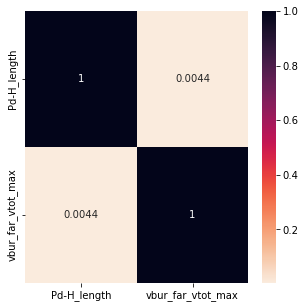

In [4]:
# Let's do an absolute heatmap (and set the color axis so that 0 is light, 1 is dark):
plt.figure(figsize= (5, 5))
cmap = sns.cm.rocket_r
abs_corr_heatmap = sns.heatmap(abs(features.corr()), annot=True, cmap=cmap)

In [5]:
# Set the feature and target values:
X = features.values
target = merged_df.columns[1]
y = merged_df[target].values

In [6]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'r

In [7]:
# I think the "best" model for us is probably the Elastic Net, so let's stick with that.

# We really need to do some hyperparameter tuning when it comes to alpha and l1_ratio. 
# Let's do a Grid Search CV
# Seems like I'd have to use Cp or some information criterion as the scoring metric?
# Those don't seem to be available. TODO: address scoring metric choice

elastic_net = ElasticNet(tol=0.0001, max_iter=1000000)

search_space = {
    # "alpha": [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200, 500, 1000],
    "alpha": [0.00000001, 0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100, 200, 500, 1000],
    "l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
}

gs_elastic_net = GridSearchCV(
    estimator=elastic_net,
    param_grid=search_space,
    scoring=["r2"],
    refit="r2",
    cv=5
)

In [8]:
# Leave-one-out CV
from sklearn.model_selection import LeaveOneOut
def loocv(X, y, model, verbose=False):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    y_preds = []
    for i, (train_indices, test_index) in enumerate(loo.split(X)):
        print(f"Fold {i}: ", end="")
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds.append(y_pred[0])
        print("complete.  ", end="")
        
        if verbose:
            print()
            print(model.best_estimator_.get_params())
            print(model.best_estimator_.coef_)
    
    print()
    return y_preds

In [9]:
y_preds = loocv(X, y, gs_elastic_net, verbose=True)
print(y_preds)

Fold 0: complete.  
{'alpha': 1e-06, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
[83.4610335   0.87067303]
Fold 1: complete.  
{'alpha': 1e-08, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
[80.20781616  0.8688115 ]
Fold 2: complete.  
{'alpha': 1e-08, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
[89.26153362  0.83184462]
Fold 3: complete.  
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_sta

In [10]:
# Compute MSE:
squared_errors = []
for i in range(len(y_preds)):
    squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
print(f"LOOCV MSE: {round((sum(squared_errors) / len(squared_errors)), 1)}")

LOOCV MSE: 134.1


In [11]:
gs_elastic_net.fit(X, y)
print(f"Linear, 2-feature coefficients: {gs_elastic_net.best_estimator_.coef_}")
print(f"Linear, 2-feature R2: {gs_elastic_net.score(X, y)}")

Linear, 2-feature coefficients: [84.0125019   0.84517346]
Linear, 2-feature R2: 0.6694804502148506


<Axes: xlabel='molecule_id'>

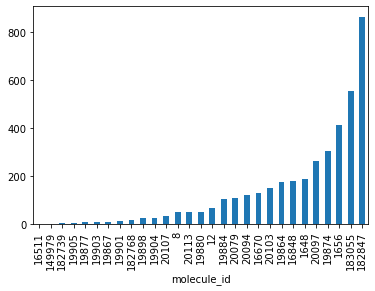

In [12]:
pd.Series(squared_errors, dft_df["molecule_id"]).sort_values(ascending = True).plot(kind = "bar")
# TODO: double check that the labels and the names are correctly corresponding
# same with the other such plots too

In [13]:
# Boostrap CV
from sklearn.utils import resample

boot = resample(X, replace=True, n_samples=len(X), random_state=1)
# print(boot)

In [14]:
# Also, how much better is out model than a 1-parameter regression with Pd-H length?
# for what that model would lack in flexibility it may just fare well due to not overfitting...
# basically, does the Kraken ML data really add anything or not, is it actually learning from that stuff
from sklearn.linear_model import LinearRegression
import numpy as np

linear_agostic = LinearRegression()
X_PdH = merged_df.loc[:, ["Pd-H_length"]].to_numpy()
linear_agostic.fit(X_PdH, y)

print(f"Linear, agostic R2: {linear_agostic.score(X_PdH, y)}")

Linear, agostic R2: 0.537289020722717


In [15]:
y_preds = loocv(X_PdH, y, linear_agostic)
print(y_preds)

Fold 0: complete.  Fold 1: complete.  Fold 2: complete.  Fold 3: complete.  Fold 4: complete.  Fold 5: complete.  Fold 6: complete.  Fold 7: complete.  Fold 8: complete.  Fold 9: complete.  Fold 10: complete.  Fold 11: complete.  Fold 12: complete.  Fold 13: complete.  Fold 14: complete.  Fold 15: complete.  Fold 16: complete.  Fold 17: complete.  Fold 18: complete.  Fold 19: complete.  Fold 20: complete.  Fold 21: complete.  Fold 22: complete.  Fold 23: complete.  Fold 24: complete.  Fold 25: complete.  Fold 26: complete.  Fold 27: complete.  Fold 28: complete.  
[394.6755164457433, 419.3005834704736, 362.55801743179586, 393.35196220130064, 374.59554158656476, 376.8066076923384, 378.7714368754143, 395.56876373728085, 406.5413829227748, 397.71404318337227, 401.5183601112217, 375.7147222606427, 402.0690442662449, 388.25644560406, 401.95564363392134, 395.97624695529237, 382.9343385556033, 369.69794591344066, 412.0252261264768, 379.4558596210981, 381.43366139126283, 391.1535062941429, 391

In [16]:
squared_errors = []
for i in range(len(y_preds)):
    squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
print(f"LOOCV MSE: {round((sum(squared_errors) / len(squared_errors)), 1)}")

LOOCV MSE: 179.0


In [17]:
# AAAAAAAAAAAGGGGGGGGGGGGGGGGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
# The simple model MSE is MUCH lower than our "optimized" elastic net.
# So clearly we are overfitting then.